In [1]:
import artif_gen_methods as agm
import config
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
%matplotlib inline

In [157]:
importlib.reload(hf)
importlib.reload(config)
importlib.reload(agm)
C = config.Config()

In [25]:
n = 1500

In [294]:
# hemangiomas add nodular enhancement, including in arterial; may fill in completely
# cholangios add variation in amount of enhancement over time
# remove fnh washout and shrink scar
# colorectal add weakly enhancing patches in delayed phase for some
# create some hcc where washout is only in delayed
# irregular shapes
# different scales between planes

agm.gen_imgs("cyst", C, n)
agm.gen_imgs("hcc", C, n)
agm.gen_imgs("hemangioma", C, n)
agm.gen_imgs("cholangio", C, n)
agm.gen_imgs("colorectal", C, n)
agm.gen_imgs("fnh", C, n)

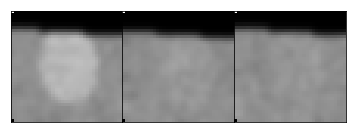

In [51]:
img = agm.gen_fnhs(C, 30)[26]
img = agm.post_process_img(img, C)
hf.plot_section_auto(img, normalize=True)

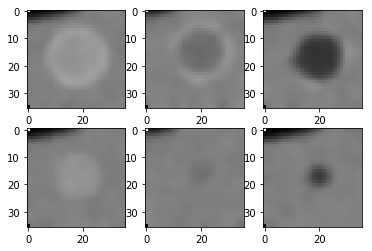

In [189]:
img = agm.gen_hccs(C, 30)[12]
img = agm.post_process_img(img, C)
hf.plot_section_auto_scan(img, 0.3)

In [58]:
cls = "fnh"
img = np.load(C.artif_dir + cls + "\\artificial_150.npy")
hf.plot_section_auto_scan(img, 0.3)

NameError: name 'np' is not defined